In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path

from tensorflow.keras.applications import resnet
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model


from tensorflow import keras
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = Path("/content/gdrive/MyDrive")

dataset_dir = root_dir / "SigNature/Datasets/SigNature_integration_HQ_augmented_2"

Pairs (anchor, positive, negatie) = (genuine, genuine, forged)

# ResNet - first try

In [ ]:
'''
import itertools as it
import random

triplets_ = []
content = os.listdir(dataset / "Train" / "1_genuine")
l = [ (a,b) for a,b in it.combinations(content, 2)]
random.shuffle(l)
content = os.listdir(dataset  / "Train" / "1_forged")
for i in range(len(content)):
  new_triplet = l[i] + (content[i], )
  triplets_.append(new_triplet)
'''

In [ ]:
import itertools as it
import random

triplets = []

path = dataset_dir / "Train"
content = os.listdir(path)

n = len(content) // 2
for i in range(1, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets.append(new_triplet)

In [ ]:
image_count = len(triplets)

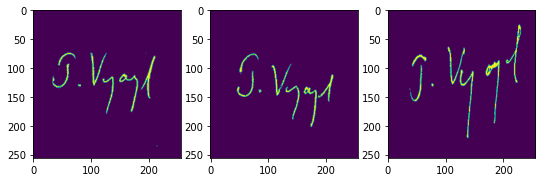

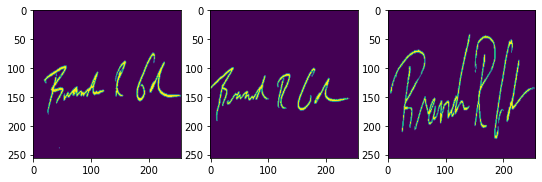

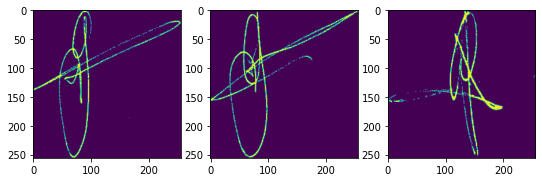

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize(triplet):
  anchor = Image.open(triplet[0])
  positive = Image.open(triplet[1])
  negative = Image.open(triplet[2])

  fig = plt.figure(figsize=(9, 9))
  axs = fig.subplots(1, 3)

  axs[0].imshow(anchor)
  axs[1].imshow(positive)
  axs[2].imshow(negative)

def rand():
  return int(random.random() * 2038)

for i in range(3):
  visualize(triplets[rand()])

In [ ]:
target_shape = (256, 256)

In [ ]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [ ]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 2038/2038 [00:00<00:00, 164428.72it/s]


In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

In [ ]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [ ]:
dataset = dataset.map(preprocess_triplets)

In [ ]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
target_shape = (256,256)

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=1, validation_data=val_dataset)

51/51 [==============================] - 51s 849ms/step - loss: 0.0577 - val_loss: 0.0149


In [ ]:
sample = next(iter(valid))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99710524
Negative similarity 0.9941754


# Simple siamese networks - writed independent approach


# TODO: Importare le triplette del vecchio test set

In [ ]:
import itertools as it
import random

triplets_train = []
triplets_test = []

path = dataset_dir / "Train"
content = os.listdir(path)

n = len(content) // 2
n_train = int(n * 0.9)

for i in range(1, n_train):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_train.append(new_triplet)

for i in range(n_train, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_test.append(new_triplet)

In [ ]:
print("Triplette nel train", len(triplets_train))
print("Triplette nel test", len(triplets_test))

Triplette nel train 4914
Triplette nel test 594


In [ ]:
image_count = len(triplets_train)

         ANCHOR              POSITIVE            NEGATIVE


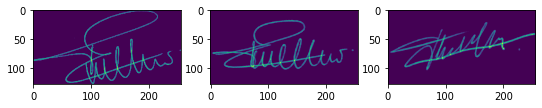

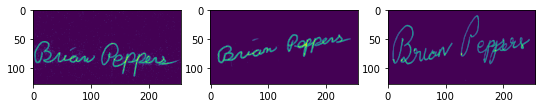

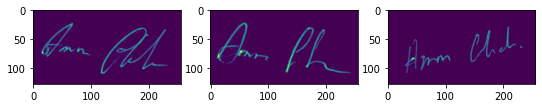

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize(triplet):
  anchor = Image.open(triplet[0])
  positive = Image.open(triplet[1])
  negative = Image.open(triplet[2])

  fig = plt.figure(figsize=(9, 9))
  axs = fig.subplots(1, 3)

  axs[0].imshow(anchor)
  axs[1].imshow(positive)
  axs[2].imshow(negative)

def rand():
  return int(random.random() * len(triplets_train))

print("         ANCHOR              POSITIVE            NEGATIVE")
for i in range(3):
  visualize(triplets_train[rand()])

In [ ]:
target_shape = (128, 256)

In [ ]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [ ]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets_train):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 4914/4914 [00:00<00:00, 117817.12it/s]


In [ ]:
# Da elim
anchor_dataset_test = []
positive_dataset_test = []
negative_dataset_test = []

def load_triplets():
  for triplet in tqdm(triplets_test):
    anchor_dataset_test.append( triplet[0].as_posix() )
    positive_dataset_test.append( triplet[1].as_posix() )
    negative_dataset_test.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 594/594 [00:00<00:00, 87188.68it/s]


In [ ]:
seed=42

In [ ]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [ ]:
#da elim
anchor_dataset_test = tf.data.Dataset.from_tensor_slices(anchor_dataset_test)
positive_dataset_test = tf.data.Dataset.from_tensor_slices(positive_dataset_test)
negative_dataset_test = tf.data.Dataset.from_tensor_slices(negative_dataset_test)

In [ ]:
#Da elim
dataset_test = tf.data.Dataset.zip((anchor_dataset_test, positive_dataset_test, negative_dataset_test))
dataset_test = dataset_test.shuffle(buffer_size=1024, seed = seed)

In [ ]:
#Da elim
dataset_test = dataset_test.map(preprocess_triplets)

In [ ]:
#Da elim
dataset_test = dataset_test.batch(1, drop_remainder=False)
dataset_test = dataset_test.prefetch(1)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024, seed=seed)

In [ ]:
dataset = dataset.map(preprocess_triplets)

In [ ]:
train_dataset = dataset.take(round(image_count * 0.9))
val_dataset = dataset.skip(round(image_count * 0.9))

train_dataset = train_dataset.shuffle(buffer_size=1024, seed=seed)
val_dataset = val_dataset.shuffle(buffer_size=1024, seed = seed)

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [ ]:
target_shape = (128, 256)

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

W_init = keras.initializers.HeNormal(seed=seed)
b_init = keras.initializers.HeNormal(seed=seed) 

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(1024, activation="relu", kernel_initializer=W_init, bias_initializer=b_init)(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(512, activation="relu", kernel_initializer=W_init, bias_initializer=b_init)(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(512)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.00006))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
139/139 [==============================] - 160s 1s/step - loss: 0.1564 - val_loss: 0.0579
Epoch 2/10
139/139 [==============================] - 148s 1s/step - loss: 0.0945 - val_loss: 0.0487
Epoch 3/10
139/139 [==============================] - 147s 1s/step - loss: 0.0633 - val_loss: 0.0448
Epoch 4/10
139/139 [==============================] - 146s 1s/step - loss: 0.0521 - val_loss: 0.0259
Epoch 5/10
139/139 [==============================] - 146s 1s/step - loss: 0.0362 - val_loss: 0.0226
Epoch 6/10
139/139 [==============================] - 146s 1s/step - loss: 0.0288 - val_loss: 0.0166
Epoch 7/10
139/139 [==============================] - 146s 1s/step - loss: 0.0238 - val_loss: 0.0060
Epoch 8/10
139/139 [==============================] - 146s 1s/step - loss: 0.0210 - val_loss: 0.0133
Epoch 9/10
139/139 [==============================] - 146s 1s/step - loss: 0.0274 - val_loss: 0.0328
Epoch 10/10
139/139 [==============================] - 145s 1s/step - loss: 0.0291 - val_lo

In [ ]:
pos_list = []
neg_list = []

for sample in dataset_test:
  anchor, positive, negative = sample
  anchor_embedding, positive_embedding, negative_embedding = (
      embedding(resnet.preprocess_input(anchor)),
      embedding(resnet.preprocess_input(positive)),
      embedding(resnet.preprocess_input(negative)),
  )


  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  pos_list.append(positive_similarity)

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  neg_list.append(negative_similarity)

In [ ]:
def mean(x):
  return sum(x)/len(x)

In [ ]:
print(mean(pos_list))
print(mean(neg_list))

0.9996063800572547
0.9991531935003068


In [ ]:
print("Min delle positive", min(pos_list))
print("Max delle negative", max(neg_list))
if min(pos_list) > max(neg_list):
  print("Esiste una threshold che separa linearmente le due classi")
threshold_val = (mean(pos_list) + mean(neg_list)) / 2
print("Una threshold possibile è ", threshold_val)

Min delle positive 0.9981236
Max delle negative 0.9998837
Una threshold possibile è  0.9993797867787808


In [ ]:
print("Questa threshold viene applicata al test set per verificare le performance")
tp = 0
tn = 0
for sample in dataset_test:
  anchor, positive, negative = sample
  
  anchor_embedding, positive_embedding, negative_embedding = (
      embedding(resnet.preprocess_input(anchor)),
      embedding(resnet.preprocess_input(positive)),
      embedding(resnet.preprocess_input(negative)),
  )
  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  if positive_similarity >= threshold_val: 
    tp += 1

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  if negative_similarity < threshold_val:
    tn += 1
  


Questa threshold viene applicata al test set per verificare le performance


In [ ]:
print("Accuracy on test set", (tp + tn)/(len(dataset_test)*2))

Accuracy on test set 0.6801346801346801


# Rete siamese - Partendo da CNN senza trasfer learning

In [ ]:
import itertools as it
import random

triplets_train = []
triplets_test = []

path = dataset_dir / "Train"
content = os.listdir(path)

n = len(content) // 2
n_train = int(n * 0.8)

for i in range(1, n_train):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_train.append(new_triplet)

for i in range(n_train, n + 1):
  folder_g = path / (str(i) + "_genuine")
  folder_f = path / (str(i) + "_forged")
  folder_g_content = os.listdir(path / folder_g)
  folder_f_content = os.listdir(path / folder_f)
  anchor_positive = [ (folder_g / a, folder_g / b) for a,b in it.combinations(folder_g_content, 2)]
  random.shuffle(anchor_positive)
  for j in range(len(folder_f_content)):
    new_triplet = anchor_positive[j] + (folder_f/folder_f_content[j], )
    triplets_test.append(new_triplet)

In [ ]:
print("Triplette nel train", len(triplets_train))
print("Triplette nel test", len(triplets_test))

Triplette nel train 4425
Triplette nel test 1083


In [ ]:
image_count = len(triplets_train)

In [ ]:
target_shape = (128, 256)

In [ ]:
def preprocess(img_path):
  raw = tf.io.read_file(img_path)
  image = tf.image.decode_png(raw, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, target_shape)
  return image

In [ ]:
anchor_dataset = []
positive_dataset = []
negative_dataset = []

def load_triplets():
  for triplet in tqdm(triplets_train):
    anchor_dataset.append( triplet[0].as_posix() )
    positive_dataset.append( triplet[1].as_posix() )
    negative_dataset.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 4425/4425 [00:00<00:00, 120924.90it/s]


In [ ]:
# Da elim
anchor_dataset_test = []
positive_dataset_test = []
negative_dataset_test = []

def load_triplets():
  for triplet in tqdm(triplets_test):
    anchor_dataset_test.append( triplet[0].as_posix() )
    positive_dataset_test.append( triplet[1].as_posix() )
    negative_dataset_test.append( triplet[2].as_posix() )

load_triplets()

100%|██████████| 1083/1083 [00:00<00:00, 95355.11it/s]


In [ ]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess(anchor),
        preprocess(positive),
        preprocess(negative),
    )

In [ ]:
#da elim
anchor_dataset_test = tf.data.Dataset.from_tensor_slices(anchor_dataset_test)
positive_dataset_test = tf.data.Dataset.from_tensor_slices(positive_dataset_test)
negative_dataset_test = tf.data.Dataset.from_tensor_slices(negative_dataset_test)

In [ ]:
#Da elim
dataset_test = tf.data.Dataset.zip((anchor_dataset_test, positive_dataset_test, negative_dataset_test))
dataset_test = dataset_test.shuffle(buffer_size=1024)

In [ ]:
#Da elim
dataset_test = dataset_test.map(preprocess_triplets)

In [ ]:
#Da elim
dataset_test = dataset_test.batch(1, drop_remainder=False)
dataset_test = dataset_test.prefetch(1)

In [ ]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_dataset)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_dataset)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_dataset)

In [ ]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

In [ ]:
dataset = dataset.map(preprocess_triplets)

In [ ]:
train_dataset = dataset.take(round(image_count * 0.9))
val_dataset = dataset.skip(round(image_count * 0.9))

train_dataset = train_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.shuffle(buffer_size=1024)

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


In [ ]:
target_shape = (128, 256, 1)

initializer = tf.keras.initializers.HeNormal(seed=42) 

model = keras.Sequential([
  layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer=initializer, activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.1, seed = 42),
  layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer=initializer, activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed = 42),
  layers.Flatten(),
  layers.Dense(1024, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.5, seed = 42),
  layers.Dense(128, activation='relu', kernel_initializer=initializer)
])


In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape)
positive_input = layers.Input(name="positive", shape=target_shape)
negative_input = layers.Input(name="negative", shape=target_shape)

distances = DistanceLayer()(
    model(anchor_input),
    model(positive_input),
    model(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
125/125 [==============================] - 83s 597ms/step - loss: 0.6237 - val_loss: 0.3328
Epoch 2/5
125/125 [==============================] - 78s 586ms/step - loss: 0.1266 - val_loss: 0.3899
Epoch 3/5
125/125 [==============================] - 78s 586ms/step - loss: 0.0358 - val_loss: 0.3577
Epoch 4/5
125/125 [==============================] - 78s 588ms/step - loss: 0.0145 - val_loss: 0.3261
Epoch 5/5
125/125 [==============================] - 78s 587ms/step - loss: 0.0178 - val_loss: 0.4636


In [ ]:
pos_list = []
neg_list = []

for sample in val_dataset:
  anchor, positive, negative = sample
  anchor_embedding, positive_embedding, negative_embedding = (
      model(anchor),
      model(positive),
      model(negative),
  )


  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  pos_list.append(positive_similarity)

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  neg_list.append(negative_similarity)

NameError: ignored

In [ ]:
def mean(x):
  return sum(x)/len(x)

In [ ]:
print(mean(pos_list))
print(mean(neg_list))

In [ ]:
print("Min delle positive", min(pos_list))
print("Max delle negative", max(neg_list))
if min(pos_list) > max(neg_list):
  print("Esiste una threshold che separa linearmente le due classi")
threshold_val = (mean(pos_list) + mean(neg_list)) / 2
print("Una threshold possibile è ", threshold_val)

In [ ]:
print("Questa threshold viene applicata al test set per verificare le performance")
tp = 0
tn = 0
for sample in dataset_test:
  anchor, positive, negative = sample
  
  anchor_embedding, positive_embedding, negative_embedding = (
      model(anchor),
      model(positive),
      model(negative),
  )
  cosine_similarity = metrics.CosineSimilarity()

  positive_similarity = cosine_similarity(anchor_embedding, positive_embedding).numpy()
  if positive_similarity >= threshold_val: 
    tp += 1

  negative_similarity = cosine_similarity(anchor_embedding, negative_embedding).numpy()
  if negative_similarity < threshold_val:
    tn += 1
  


Questa threshold viene applicata al test set per verificare le performance


In [ ]:
print("Accuracy on test set", (tp + tn)/(len(dataset_test)*2))

Accuracy on test set 0.6826599326599326
